Bayesian Optimitization Demo
-----

[Source](https://scikit-optimize.github.io/notebooks/bayesian-optimization.html)

In [1]:
reset -fs

In [6]:
import matplotlib.pyplot as plt
import numpy as np

try:
    from skopt import gp_minimize
except ModuleNotFoundError:
    import pip
    pip.main(['install', 'scikit-optimize'])
    from skopt import gp_minimize

%matplotlib inline

Toy Data time
-----

![](https://s-media-cache-ak0.pinimg.com/736x/84/4a/d4/844ad4bcc5aae399997a6951e0de1929.jpg)

In [31]:
noise_level = .4 #.1 = Low noise, .4 = high-ish noise

# def f(x, noise_level=noise_level):
#     "Simple is as simple does"
#     return (x[0]-1)**2 + (np.random.randn() * noise_level)

# def f(x, noise_level=noise_level):
#     "I'm a inverse hat 👒"
#     return -np.sin(10 * x[0])/(10 * x[0]) + (np.random.randn() * noise_level)

def f(x, noise_level=noise_level):
    "Bumps in the road"
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + (np.random.randn() * noise_level)

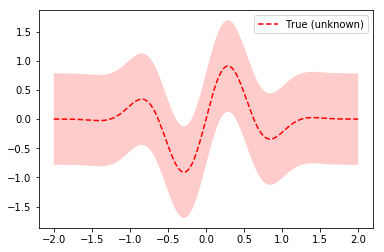

In [32]:
# Plot f(x) + contours
bounds = (-2.0, 2.0)
x = np.linspace(bounds[0], bounds[1], 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
# plt.grid()
plt.show()

In [33]:
results = gp_minimize(f,              # the function to minimize
                  [bounds],           # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function, Expected Improvement
                  n_calls=25,         # the number of evaluations of f 
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=123)   # the random seed

In [34]:
# print(results)

In [35]:
minimum_value = results.fun
print(f"{minimum_value:.3}")

-1.01


In [36]:
minimum_value_location = results.x[0]
print(f"{minimum_value_location:.3}")

-1.52


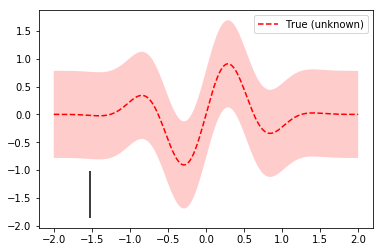

In [37]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
axes = plt.gca()
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.vlines(minimum_value_location, ymin=axes.get_ylim()[0], ymax=minimum_value)
# plt.grid()
plt.show()

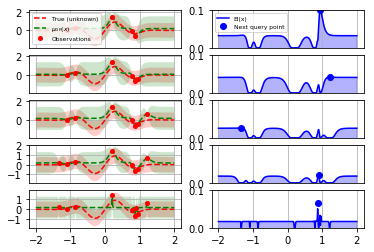

In [38]:
from skopt.acquisition import gaussian_ei

x = np.linspace(-2, 2, 400).reshape(-1, 1)
x_gp = results.space.transform(x.tolist())
fx = np.array([f(x_i, noise_level=0.0) for x_i in x])

# Plot the 5 iterations following the 5 random points
for n_iter in range(5):
    gp = results.models[n_iter]
    curr_x_iters = results.x_iters[:5+n_iter]
    curr_func_vals = results.func_vals[:5+n_iter]

    # Plot true function.
    plt.subplot(5, 2, 2*n_iter+1)
    plt.plot(x, fx, "r--", label="True (unknown)")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([fx - 1.9600 * noise_level, 
                             fx[::-1] + 1.9600 * noise_level]),
             alpha=.2, fc="r", ec="None")

    # Plot GP(x) + contours
    y_pred, sigma = gp.predict(x_gp, return_std=True)
    plt.plot(x, y_pred, "g--", label=r"$\mu_{GP}(x)$")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma, 
                             (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.2, fc="g", ec="None")

    # Plot sampled points
    plt.plot(curr_x_iters, curr_func_vals,
             "r.", markersize=8, label="Observations")

    # Adjust plot layout
    plt.grid()

    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 6}, numpoints=1)

    if n_iter != 4:
        plt.tick_params(axis='x', which='both', bottom='off', 
                        top='off', labelbottom='off') 

    # Plot EI(x)
    plt.subplot(5, 2, 2*n_iter+2)
    acq = gaussian_ei(x_gp, gp, y_opt=np.min(curr_func_vals))
    plt.plot(x, acq, "b", label="EI(x)")
    plt.fill_between(x.ravel(), -2.0, acq.ravel(), alpha=0.3, color='blue')

    next_x = results.x_iters[5+n_iter]
    next_acq = gaussian_ei(results.space.transform([next_x]), gp, y_opt=np.min(curr_func_vals))
    plt.plot(next_x, next_acq, "bo", markersize=6, label="Next query point")

    # Adjust plot layout
    plt.ylim(0, 0.1)
    plt.grid()

    if n_iter == 0:
        plt.legend(loc="best", prop={'size': 6}, numpoints=1)

    if n_iter != 4:
        plt.tick_params(axis='x', which='both', bottom='off', 
                        top='off', labelbottom='off') 

plt.show()

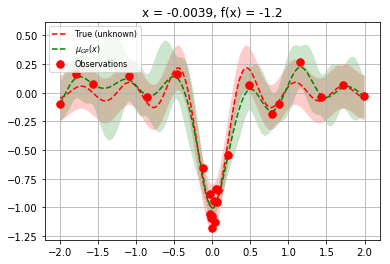

In [23]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
x_gp = results.space.transform(x.tolist())

fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx], 
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")

# Plot GP(x) + contours
gp = results.models[-1]
y_pred, sigma = gp.predict(x_gp, return_std=True)

plt.plot(x, y_pred, "g--", label=r"$\mu_{GP}(x)$")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma, 
                         (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.2, fc="g", ec="None")

# Plot sampled points
plt.plot(results.x_iters, 
         results.func_vals, 
         "r.", markersize=15, label="Observations")

plt.title(f"x = {results.x[0]:.2}, f(x) = {results.fun:.2}")
plt.legend(loc="best", prop={'size': 8}, numpoints=1)
plt.grid()

plt.show()

<br>
<br> 
<br>

----